In [88]:
from collections import defaultdict
from math import sqrt
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import tqdm.notebook as tq
import random
import math
import time
from collections import defaultdict
import matplotlib.pyplot as plt

In [5]:
class Derivative:
    """ Enabling the usage of +, *, -, etc. """
    def __add__(self, other):
        return Add(self, other)
    
    def __radd__(self, other):
        return rAdd(self, other)
    
    def __sub__(self, other):
        return Sub(self, other)

    def __rsub__(self, other):
        return rSub(self, other)
    
    def __mul__(self, other):
        return Mul(self, other)
    
    def __rmul__(self, other):
        return rMul(self, other)
    
    def __truediv__(self, other):
        return Div(self, other)

    def __rtruediv__(self, other):
        return rDiv(self, other)
   
    def Sin(self):
        return Sin(self)
    
    def __pow__(self, power):
        return Pow(self, power)
    
    def Exp(self):
        return Exp(self)
    
    def Cdf(self):
        return Cdf(self)
    
    def __ge__(self, other):
        return Ge(self, other)
    
    def __le__(self, other):
        return Le(self, other)
    
    def __hash__(self):                 # we need this for creating the dictionary with keys as Derivatives object
        return hash(str(self))

Leaf nodes

In [6]:
class Var(Derivative):
    """ A leaf node (a node which doesn't have any child) """
    
    def __init__(self, value):
        self.value = value      # the scalar value of the node

Adding the nodes

In [7]:
class Add(Derivative):
    """ The node that results from adding two nodes """
    def __init__(self, node_a, node_b):
        if isinstance(node_a, (int, float, np.ndarray)): 
            self.value = node_a + node_b.value
            self.grad = [(node_b, 1)]
        elif isinstance(node_b, (int, float, np.ndarray)): 
            self.value = node_a.value + node_b
            self.grad = [(node_a, 1)]
        else:      
            self.value = node_a.value + node_b.value    # value of the node
            self.grad = [(node_a, 1), (node_b, 1)]      # partial derivatives of nodes - value 1 for derivative in respect to node_a and 1 for node_b

In [8]:
class rAdd(Derivative):
    """ The node that results from adding two nodes """
    def __init__(self, node_a, node_b):
        if isinstance(node_b, (int, float)): 
            self.value = node_b + node_a.value
            self.grad = [(node_a, 1)]
        elif isinstance(node_a, (int, float)): 
            self.value = node_b.value + node_a
            self.grad = [(node_b, 1)]
        else:      
            self.value = node_b.value + node_a.value    # value of the node
            self.grad = [(node_b, 1), (node_a, 1)]      # partial derivatives of nodes - value 1 for derivative in respect to node_a and 1 for node_b

Substract the nodes

In [9]:
class Sub(Derivative):
    """ The node that results from subtracting two nodes """
    def __init__(self, node_a, node_b):
        if isinstance(node_a, (int, float)): 
            self.value = node_a - node_b.value
            self.grad = [(node_b, -1)]
        elif isinstance(node_b, (int, float)): 
            self.value = node_a.value - node_b
            self.grad = [(node_a, 1)]
        else:      
            self.value = node_a.value - node_b.value    # value of the node
            self.grad = [(node_a, 1), (node_b, -1)]     # partial derivatives of nodes - should have again the structure as [(node_a, value), (node_b, value)]

In [10]:
class rSub(Derivative):
    """ The node that results from subtracting two nodes """
    def __init__(self, node_a, node_b):
        if isinstance(node_b, (int, float)): 
            self.value = node_b - node_a.value
            self.grad = [(node_a, -1)]
        elif isinstance(node_a, (int, float)): 
            self.value = node_b.value - node_a
            self.grad = [(node_b, 1)]
        else:      
            self.value = node_b.value - node_a.value    # value of the node
            self.grad = [(node_b, 1), (node_a, -1)]     # partial derivatives of nodes - should have again the structure as [(node_a, value), (node_b, value)]

Multiplication of nodes

In [11]:
class Mul(Derivative):
    """ The node that results from multiplying two nodes """
    def __init__(self, node_a, node_b):
        if isinstance(node_a, (int, float, np.ndarray)): 
            self.value = node_a * node_b.value
            self.grad = [(node_b, node_a)]
        elif isinstance(node_b, (int, float, np.ndarray)): 
            self.value = node_a.value * node_b
            self.grad = [(node_a, node_b)]
        else:      
            self.value = node_a.value * node_b.value
            self.grad = [(node_a, node_b.value), (node_b, node_a.value)]        # f = x*y   df / dx = y   df / dy = x

In [12]:
class rMul(Derivative):
    """ The node that results from multiplying two nodes """
    def __init__(self, node_a, node_b):
        if isinstance(node_b, (int, float, np.ndarray)): 
            self.value = node_b * node_a.value
            self.grad = [(node_a, node_b)]
        elif isinstance(node_a, (int, float, np.ndarray)): 
            self.value = node_b.value * node_a
            self.grad = [(node_b, node_a)]
        else:      
            self.value = node_b.value * node_a.value
            self.grad = [(node_b, node_a.value), (node_a, node_b.value)]                                # f = x*y   df / dx = y   df / dy = x

Dividing nodes

In [13]:
class Div(Derivative):
    """ The node that results from dividing one node by another """
    def __init__(self, node_a, node_b):
        if isinstance(node_a, (int, float)): 
            self.value = node_a / node_b.value
            self.grad = [(node_b, -node_a/(node_b.value**2))]
        elif isinstance(node_b, (int, float)): 
            self.value = node_a.value / node_b
            self.grad = [(node_a, 1/node_b)]
        else:      
            self.value = node_a.value / node_b.value
            self.grad = [(node_a, 1/node_b.value), (node_b, -node_a.value/(node_b.value**2))]           # f = x/y   df / dx = 1/y    df / dy = -x / (y^2)

In [14]:
class rDiv(Derivative):
    """ The node that results from dividing one node by another """
    def __init__(self, node_a, node_b):
        if isinstance(node_b, (int, float)): 
            self.value = node_b / node_a.value
            self.grad = [(node_a, -node_b/(node_a.value**2))]
        elif isinstance(node_a, (int, float)): 
            self.value = node_b.value / node_a
            self.grad = [(node_b, 1/node_a)]
        else:      
            self.value = node_b.value / node_a.value
            self.grad = [(node_b, 1/node_a.value), (node_a, -node_b.value/(node_a.value**2))]           # f = x/y   df / dx = 1/y    df / dy = -x / (y^2)

Logarithm of one mode

In [15]:
class Log(Derivative):
    """ The node that results from sin(node) """
    
    def __init__(self, node):
        if isinstance(node, (int, float)): 
            self.value = np.log(node) 
            self.grad = [(node, 0)]
        else:
            self.value = np.log(node.value)                          
            self.grad = [(node, 1/node.value)]                 

Sinus of one node

In [16]:
class Sin(Derivative):
    """ The node that results from sin(node) """
    
    def __init__(self, node):
        if isinstance(node, (int, float)): 
            self.value = np.sin(node) 
            self.grad = [(node, 0)]
        else:
            self.value = np.sin(node.value)                          # use np.sin() function
            self.grad = [(node, np.cos(node.value))]                 # only one derivative, since it takes only one node - use np.cos() function

Cosinus of one node

In [17]:
class Cos(Derivative):
    """ The node that results from cos(node) """
    
    def __init__(self, node):
        if isinstance(node, (int, float)): 
            self.value = np.cos(node)
            self.grad = [(node, 0)]
        else:
            self.value = np.cos(node.value)                          
            self.grad = [(node, -np.sin(node.value))]                

Powers

In [18]:
class Pow(Derivative):
    """ The node that results as node ^ power """
    
    def __init__(self, node, power):
        self.value = node.value**power                                         # reminder of power operation in python: **
        self.grad = [(node, power*node.value**(power-1))]                      # (one derivative)    f = x^n   df/dx = n * x ^ (n-1)

Exponential

In [19]:
class Exp(Derivative):
    """ The node that results from exp(node) """

    def __init__(self, node):
        if isinstance(node, (int, float)): 
            self.value = np.exp(node)  
            self.grad = [(node, 0)]
        else:
            self.value = np.exp(node.value)                         
            self.grad = [(node, np.exp(node.value))]   

Squareroot

In [20]:
class Sqrt(Derivative):
    """ The node that results from sqrt(node) """
    
    def __init__(self, node):
        if isinstance(node, (int, float)): 
            self.value = np.sqrt(node)
            self.grad = [(node, 0)]
        else:
            self.value = np.sqrt(node.value)                  
            self.grad = [(node, 1/(2*np.sqrt(node.value)))]  

$ a^x $

In [21]:
class Pot(Derivative):
    """ The node that results from a ^ node """
    
    def __init__(self, a, node):
        self.value = a**node.value                          
        self.grad = [(node, a**node.value * np.log(a))]                

Cdf

In [22]:
class Cdf(Derivative):
    """ The node that results from cdf(node) """

    def __init__(self, node):
        if isinstance(node, (int, float)): 
            self.value = norm.cdf(node) 
            self.grad = [(node, norm.pdf(node) )]
        else:
            self.value = norm.cdf(node.value)            
            self.grad = [(node, norm.pdf(node.value))]

Overskrivning af >= og <=

In [23]:
class Ge(Derivative):
    """ >= """
            
    def __init__(self, node_a, node_b):
        if isinstance(node_a, (int, float)): 
            self.value = node_a >= node_b.value
        elif isinstance(node_b, (int, float)): 
            self.value = node_a.value >= node_b
        else:      
            self.value = node_a.value >= node_b.value

In [24]:
class Le(Derivative):
    """ <= """

    def __init__(self, node_a, node_b):
        if isinstance(node_a, (int, float)): 
            self.value = node_a <= node_b.value
        elif isinstance(node_b, (int, float)): 
            self.value = node_a.value <= node_b
        else:      
            self.value = node_a.value <= node_b.value

### Create a function for getting the gradients values

In [36]:
def Get_Gradient(parent_node):
    """ Go down the graph, and compute derivative of `parent_node` with respect to each node """
    
    # we will create a dictionary 'gradient' which will have the nodes as keys and its derivatives as values
    gradients = defaultdict(lambda: 0)    # initialize the dictionary so when calling a non-existing key the value of 0 is assigned
    
    # stack will represent the list of tuples (node, node_derivative) 
    stack = parent_node.grad.copy()
    
    while stack:                             # loop for each different branch
        # get node and node_derivative from the top of the stack - function pop()
        temp = stack.pop()                   
        node = temp[0]
        node_derivative = temp[1]            
        # add to the value of derivative of the node (gradients[node]) value node_derivative
        gradients[node] = gradients[node] + node_derivative  
        
        if not isinstance(node, Var):        # if the node has children, put them onto the stack
            # loop for each node in one branch
            for child_node, child_node_derivative in node.grad:                   
                # append child_node and child_node_derivative * node_derivative to the stack
                stack.append((child_node, child_node_derivative * node_derivative))
                
    return dict(gradients)

### Test: AAD

In [26]:
S0_val = 100
K_val = 90
T_val = 1
t_val = 0
r_val = 0.07
sigma_val = 0.2
S0 = Var(S0_val)
K = Var(K_val)
T = Var(T_val)
t = Var(t_val)
r = Var(r_val)
sigma = Var(sigma_val)

def AAD_BS(S0, K, T, t, r, sigma):
    
    def BS_Price_European_Options(S0, K, T, t, r, sigma): 
        d1 = (Log(S0/K)+(r+(1/2)*(sigma**2))*(T-t))/(sigma*Sqrt((T-t)))
        d2 = d1 - sigma*Sqrt((T-t))

        euro_call = S0*Cdf(d1) - K*Exp((-1)*r*(T-t))*Cdf(d2)
        
        return euro_call
    
    price = BS_Price_European_Options(S0, K, T, t, r, sigma)
    gradients = Get_Gradient(price)
    
    adjoints = defaultdict(int)
    
    adjoints["S_"] = gradients[S0]
    adjoints["T_"] = gradients[T]
    adjoints["t_"] = gradients[t]
    adjoints["r_"] = gradients[r]
    adjoints["sigma_"] = gradients[sigma]
    
    return price.value, adjoints

In [27]:
start_time = time.time()
print(AAD_BS(S0, K, T, t, r, sigma))
print("--- %s seconds ---" % (time.time() - start_time))

[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
(17.998284796414808, defaultdict(<class 'int'>, {'S_': 0.8356665503075957, 'T_': 7.065614005003821, 't_': -7.065614005003821, 'r_': 65.56837023434477, 'sigma_': 24.758280885996857}))
--- 0.005434751510620117 seconds ---


In [28]:
t0 = time.time()

for i in range(1000000):
    AAD_BS(S0, K, T, t, r, sigma)

t1 = time.time()
avg = (t1 - t0)/1000000

print( "Average Time Taken", avg)

[(<__main__.Mul object at 0x0000019077B2B970>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B970>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0D0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B580>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA60>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BA60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BA60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BA60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BA60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B940>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFA0>, 1), (<__main__.Mul object at 0x0000019077B2B940>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BC10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B970>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0D0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADF0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A190>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A190>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A190>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A190>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A190>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A190>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A190>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A190>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A190>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A190>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A190>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A640>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A640>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A640>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A640>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A640>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A250>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A640>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x00000190757AEEE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077AEAE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A490>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A070>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A5E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A640>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AF10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A640>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0AE80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B910>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BE80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BF40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B280>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2BCD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B1C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B490>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B8B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BC70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B0A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B250>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B6A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BD00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BF70>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B400>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BB50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2BB20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCD0>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000019077B2BBB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2B880>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B340>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B040>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2BF10>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A430>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0ADC0>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0A9D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A940>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AF40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AD60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A370>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A340>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A520>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A610>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A730>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A820>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AC70>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0A730>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A910>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AD00>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0AE50>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0ABB0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AC10>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD90>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0AC40>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AD60>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0AA60>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0A550>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A310>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC10>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB50>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A3D0>, 1), (<__main__.Mul object at 0x0000019077B0A6D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0AFA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0AE20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A220>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A700>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0A3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF70>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A580>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AB50>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A0A0>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0A760>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A2E0>, 1), (<__main__.Mul object at 0x0000019077B0AEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9D0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0A400>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0AB80>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0AAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A550>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A640>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0A6D0>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAF0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF40>, 1), (<__main__.Mul object at 0x0000019077B0A2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4F0>, 1), (<__main__.Mul object at 0x0000019077B0A400>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A310>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A700>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A250>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A1F0>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A940>, 1), (<__main__.Mul object at 0x0000019077B0ADC0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0AAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A760>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA90>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE50>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACD0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000019077B0AB20>, -1)]
[(<__main__.Mul object at 0x0000019077B0A910>, 1), (<__main__.Mul object at 0x0000019077B0AFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAF0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B310>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B790>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BA00>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEB0>, 1), (<__main__.Mul object at 0x0000019077B2B5B0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B2E0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B4C0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2BAF0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2B190>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE80>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B550>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2BD60>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BBB0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2BFD0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF40>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BA30>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B3D0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B5B0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B910>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B430>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B220>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2BCA0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF70>, 1), (<__main__.Mul object at 0x0000019077B2B3D0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BA90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B7F0>, 1), (<__main__.Mul object at 0x0000019077B2BB80>, -1)]
[(<__main__.Mul object at 0x0000019077B2B190>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1C0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2BAC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BE50>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B3A0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B520>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B0A0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA30>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B880>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BDC0>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B130>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B490>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2BC40>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B1F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000019077B2BDC0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BF10>, 1), (<__main__.Mul object at 0x0000019077B2BD90>, -1)]
[(<__main__.Mul object at 0x0000019077B2B160>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B6A0>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B7F0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BEB0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A820>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A370>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AA90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0ACA0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE80>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A5E0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0AB20>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A580>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A9A0>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A430>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFA0>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AC70>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0ACD0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A610>, 1), (<__main__.Mul object at 0x0000019077B0A4F0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA00>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2BAC0>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000019077B2B220>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B070>, -1)]
[(<__main__.Mul object at 0x0000019077B2BEE0>, 1), (<__main__.Mul object at 0x0000019077B2BE20>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC70>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BE20>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B310>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2B640>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B4C0>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BCA0>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB80>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BB20>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2BC40>, 1), (<__main__.Mul object at 0x0000019077B2B130>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AB80>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AFD0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AF10>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A490>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AD00>, 1), (<__main__.Mul object at 0x0000019077B0A9A0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABE0>, 1), (<__main__.Mul object at 0x0000019077B0AD90>, -1)]
[(<__main__.Mul object at 0x0000019077B0AA60>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B0A220>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A070>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A520>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0ABB0>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0A4C0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0A340>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0ACA0>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AEE0>, 1), (<__main__.Mul object at 0x0000019077B0AF70>, -1)]
[(<__main__.Mul object at 0x0000019077B0AE20>, 1), (<__main__.Mul object at 0x0000019077B0ABE0>, -1)]
[(<__main__.Mul object at 0x0000019077B0AAC0>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BD90>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD60>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B8B0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B340>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B2E0>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BFD0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2BD00>, 1), (<__main__.Mul object at 0x0000019077B2BEE0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B1F0>, 1), (<__main__.Mul object at 0x0000019077B2B3A0>, -1)]
[(<__main__.Mul object at 0x0000019077B2B070>, 1), (<__main__.Mul object at 0x0000

[(<__main__.Mul object at 0x0000019077B2BB50>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B250>, 1), (<__main__.Mul object at 0x0000019077B2B160>, -1)]
[(<__main__.Mul object at 0x0000019077B2B520>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B400>, 1), (<__main__.Mul object at 0x0000019077B2B430>, -1)]
[(<__main__.Mul object at 0x0000019077B2B280>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B790>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B9A0>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2B550>, 1), (<__main__.Mul object at 0x0000019077B2BE50>, -1)]
[(<__main__.Mul object at 0x0000019077B2B040>, 1), (<__main__.Mul object at 0x0000019077B2B640>, -1)]
[(<__main__.Mul object at 0x0000019077B2BA90>, 1), (<__main__.Mul object at 0x0000

KeyboardInterrupt: 

### Test: Finite Difference

In [25]:
S0 = 100
K = 90
T = 1
t = 0
r = 0.07
sigma = 0.2

def Finite_Difference_BS(S0, K, T, t, r, sigma, h):
    
    def BS_Price_European_Options(S0, K, T, t, r, sigma): 
        d1 = (np.log(S0/K)+(r+1/2*(sigma**2))*(T-t))/(sigma*np.sqrt((T-t)))
        d2 = d1 - sigma*np.sqrt((T-t))

        euro_call = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
    
        return euro_call
    
    price = BS_Price_European_Options(S0, K, T, t, r, sigma)
    
    adjoints = defaultdict(int)
    
    adjoints["S_"] = (BS_Price_European_Options(S0 +h, K, T, t, r, sigma) - BS_Price_European_Options(S0, K, T, t, r, sigma)) / h
    adjoints["t_"] = (BS_Price_European_Options(S0, K, T, t+h, r, sigma) - BS_Price_European_Options(S0, K, T, t, r, sigma)) / h
    adjoints["r_"] = (BS_Price_European_Options(S0 , K, T, t, r+h, sigma) - BS_Price_European_Options(S0, K, T, t, r, sigma)) / h
    adjoints["sigma_"] = (BS_Price_European_Options(S0 , K, T, t, r, sigma+h) - BS_Price_European_Options(S0, K, T, t, r, sigma)) / h
    
    return price, adjoints

In [ ]:
### h = 0.00001 ###

start_time = time.time()
print(Finite_Difference_BS(S0, K, T, t, r, sigma, 0.00001))
print("--- %s seconds ---" % (time.time() - start_time))

In [26]:
### h = 0.000000001 ###

start_time = time.time()
print(Finite_Difference_BS(S0, K, T, t, r, sigma, 0.000000001))
print("--- %s seconds ---" % (time.time() - start_time))

(17.998284796414808, defaultdict(<class 'int'>, {'S_': 0.835683522382169, 't_': -7.065608542689006, 'r_': 65.56835785431758, 'sigma_': 24.758264771662652}))
--- 0.003002643585205078 seconds ---


In [254]:
t0 = time.time()

for i in range(1000000):
    Finite_Difference_BS(S0, K, T, t, r, sigma, 0.000000001)

t1 = time.time()
avg = (t1 - t0)/1000000

print( "Average Time Taken", avg)

Average Time Taken 0.0014697328860759735


### Test: Finite Central Difference

In [29]:
S0 = 100
K = 90
T = 1
t = 0
r = 0.07
sigma = 0.2

def Finite_Central_Difference_BS(S0, K, T, t, r, sigma, h):
    
    def BS_Price_European_Options(S0, K, T, t, r, sigma): 
        d1 = (np.log(S0/K)+(r+1/2*(sigma**2))*(T-t))/(sigma*np.sqrt((T-t)))
        d2 = d1 - sigma*np.sqrt((T-t))

        euro_call = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
    
        return euro_call
    
    price = BS_Price_European_Options(S0, K, T, t, r, sigma)
    
    adjoints = defaultdict(int)
    
    adjoints["S_"] = (BS_Price_European_Options(S0+h, K, T, t, r, sigma) - BS_Price_European_Options(S0-h, K, T, t, r, sigma)) / (2*h)
    adjoints["t_"] = (BS_Price_European_Options(S0, K, T, t+h, r, sigma) - BS_Price_European_Options(S0, K, T, t-h, r, sigma)) / (2*h)
    adjoints["r_"] = (BS_Price_European_Options(S0, K, T, t, r+h, sigma) - BS_Price_European_Options(S0, K, T, t, r-h, sigma)) / (2*h)
    adjoints["sigma_"] = (BS_Price_European_Options(S0, K, T, t, r, sigma+h) - BS_Price_European_Options(S0, K, T, t, r, sigma-h)) / (2*h)
    
    return price, adjoints

In [31]:
### h = 0.00001 ###

start_time = time.time()
print(Finite_Central_Difference_BS(S0, K, T, t, r, sigma, 0.00001))
print("--- %s seconds ---" % (time.time() - start_time))

(17.998284796414808, defaultdict(<class 'int'>, {'S_': 0.8356665503583826, 't_': -7.0656140060521, 'r_': 65.56837022344553, 'sigma_': 24.758280867587242}))
--- 0.006993770599365234 seconds ---


In [30]:
### h = 0.000000001 ###

start_time = time.time()
print(Finite_Central_Difference_BS(S0, K, T, t, r, sigma, 0.000000001))
print("--- %s seconds ---" % (time.time() - start_time))

(17.998284796414808, defaultdict(<class 'int'>, {'S_': 0.835683522382169, 't_': -7.065608542689006, 'r_': 65.56835785431758, 'sigma_': 24.758278982517368}))
--- 0.003962039947509766 seconds ---


In [32]:
t0 = time.time()

for i in range(1000000):
    Finite_Central_Difference_BS(S0, K, T, t, r, sigma, 0.000000001)

t1 = time.time()
avg = (t1 - t0)/1000000

print( "Average Time Taken", avg)

Average Time Taken 0.0020613872783184052


### Test: Eksplicit Black-Scholes

In [61]:
S0 = 100
K = 90
T = 1
r = 0.07
sigma = 0.2
# S0 = 1473.32
# K = 1500
# T = 28/365
t = 0
# r = 0.0043
# sigma = 0.16335

def Black_Scholes_Eksplicit(S0, K, T, t, r, sigma):
    
    d1 = (np.log(S0/K)+(r+1/2*(sigma**2))*(T-t))/(sigma*np.sqrt((T-t)))
    d2 = d1 - sigma*np.sqrt((T-t))

    price = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
    
    adjoints = defaultdict(int)
    
    adjoints["S_"] = norm.cdf(d1)
    adjoints["r_"] = K*(T-0)*np.exp(-r*(T-0))*norm.cdf(d2)
    adjoints["t_"] = -(S0*sigma*norm.pdf(d1))/(2*np.sqrt(T-0)) - r*K*np.exp(-r*(T-0))*norm.cdf(d2)
    adjoints["sigma_"] = S0*norm.pdf(d1)*np.sqrt(T-0)
    
    return price, adjoints

In [62]:
start_time = time.time()
print(Black_Scholes_Eksplicit(S0, K, T, t, r, sigma))
print("--- %s seconds ---" % (time.time() - start_time))

(17.998284796414808, defaultdict(<class 'int'>, {'S_': 0.8356665503075962, 'r_': 65.56837023434481, 't_': -7.06561400500382, 'sigma_': 24.75828088599683}))
--- 0.0047719478607177734 seconds ---


In [257]:
t0 = time.time()

for i in range(1000000):
    Black_Scholes_Eksplicit(S0, K, T, t, r, sigma)

t1 = time.time()
avg = (t1 - t0)/1000000

print( "Average Time Taken", avg)

Average Time Taken 0.0006117139403820038


### Test af beregningshastighed

In [130]:
S0_val = 100
K_val = 90
T_val = 1
r_val = 0.07
sigma_val = 0.2
n_simulations = 500000
n_steps = 1

S0 = Var(S0_val)
K = Var(K_val)
T = Var(T_val)
r = Var(r_val)
sigma = Var(sigma_val)

#### AAD

In [131]:
def European_Option_Price_Adjoints(S0, K, T, r, sigma, n_simulations, n_steps):
    timeline = np.arange(0, T.value, 1/n_steps)
    np.random.seed(4321)
    Z = np.random.normal(0, 1, size = (n_simulations , len(timeline)))
    
    def European_Option_Price(S0, K, T, r, sigma, Z):
        dt = T/n_steps
        d1 = r - (sigma**2) / 2
        d2 = d1 * dt + sigma * Sqrt(dt) * Z 
        S0 = S0 * Exp(d2)
        if ((S0 - K).value >= 0) == True:
            return (S0 - K) * Exp((-1) * r * T)
        else:
            return (S0 - K) * 0 * Exp((-1) * r * T)
    
    price = []
    adjoints = defaultdict(int)
    
    for i in tqdm(Z[:,-1]):
        y = European_Option_Price(S0, K, T, r, sigma, i)
        gradients = Get_Gradient(y)
        price.append(y.value)
        adjoints["S_"] += gradients[S0]/n_simulations
        adjoints["T_"] += gradients[T]/n_simulations
        adjoints["r_"] += gradients[r]/n_simulations
        adjoints["sigma_"] += gradients[sigma]/n_simulations
    
    price = np.mean(price)
    
    return price, adjoints

In [132]:
start_time = time.time()
European_Option = European_Option_Price_Adjoints(S0, K, T, r, sigma, n_simulations, n_steps)
print(European_Option)
print("--- %s seconds ---" % (time.time() - start_time))

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [00:57<00:00, 8640.88it/s]

(18.00570229777664, defaultdict(<class 'int'>, {'S_': 0.8362556537210554, 'T_': 7.069244028009966, 'r_': 65.61986307453391, 'sigma_': 24.758536128069085}))
--- 57.95148515701294 seconds ---


#### Finite Difference

In [133]:
def European_Option_Price_Finite_Difference(S0, K, T, r, sigma, n_simulations, n_steps, h):
    timeline = np.arange(0, T.value, 1/n_steps)
    np.random.seed(4321)
    Z = np.random.normal(0, 1, size = (n_simulations , len(timeline)))
    
    def European_Option_Price(S0, K, T, r, sigma, Z):
        dt = T/n_steps
        d1 = r - (sigma**2) / 2
        d2 = d1 * dt + sigma * Sqrt(dt) * Z 
        S0 = S0 * Exp(d2)
        if ((S0 - K).value >= 0) == True:
            return (S0 - K) * Exp((-1) * r * T)
        else:
            return (S0 - K) * 0 * Exp((-1) * r * T)
    
    price = []
    adjoints = defaultdict(int)
    
    for i in tqdm(Z[:,-1]):
        y = European_Option_Price(S0, K, T, r, sigma, i)
        
        price.append(y.value)
    
        adjoints["S_"] += (((European_Option_Price(S0+h, K, T, r, sigma, i) - European_Option_Price(S0-h, K, T, r, sigma, i)) / (2*h)).value)/n_simulations
        adjoints["T_"] += (((European_Option_Price(S0, K, T+h, r, sigma, i) - European_Option_Price(S0, K, T-h, r, sigma, i)) / (2*h)).value)/n_simulations
        adjoints["r_"] += (((European_Option_Price(S0, K, T, r+h, sigma, i) - European_Option_Price(S0, K, T, r-h, sigma, i)) / (2*h)).value)/n_simulations
        adjoints["sigma_"] += (((European_Option_Price(S0, K, T, r, sigma+h, i) - European_Option_Price(S0, K, T, r, sigma-h, i)) / (2*h)).value)/n_simulations
    
    price = np.mean(price)
    
    return price, adjoints

In [134]:
start_time = time.time()
European_Option_FD = European_Option_Price_Finite_Difference(S0, K, T, r, sigma, n_simulations, n_steps, 0.000000001)
print(European_Option_FD)
print("--- %s seconds ---" % (time.time() - start_time))

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [02:10<00:00, 3834.81it/s]


(18.00570229777664, defaultdict(<class 'int'>, {'S_': 0.8362587013122122, 'T_': 7.069245480483126, 'r_': 65.61986396624938, 'sigma_': 24.7585359015795}))
--- 130.46667957305908 seconds ---


### Plot

In [118]:
time_FD = []
temp = np.arange(0, 100001, 1000)
for i in tq.tqdm(temp):
    start_time = time.time()
    European_Option_Price_Finite_Difference(S0, K, T, r, sigma, i, n_steps, 0.000000001)
    time_FD.append((time.time() - start_time))


0it [00:00, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4218.90it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3780.67it/s]

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 4103.97it/s]

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 4153.71it/s]

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3912.25it/s]

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:01<00:00, 4056.70it/s]

 61%|██████████████████████████████████████████████                              | 4239/7000 [00:01<00:00, 4239.72it/s]


100%|████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:01<00:00, 4182.74it/s]

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 3653.70it/s]

100%|████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:02<00:00, 4088.98it/s]

 67%|██████████████████████████████████████████████████▌                        | 6743/10000 [00:01<00:00, 4133.60it/s]


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4054.21it/s]

100%|██████████████████████████████████████████████████████████████████████████| 11000/11000 [00:02<00:00, 4244.57it/s]

100%|██████████████████████████████████████████████████████████████████████████| 12000/12000 [00:02<00:00, 4170.16it/s]

 10%|███████▍                                                                   | 1289/13000 [00:00<00:02, 4307.29it/s]


100%|██████████████████████████████████████████████████████████████████████████| 13000/13000 [00:03<00:00, 4223.49it/s]

 95%|██████████████████████████████████████████████████████████████████████▏   | 13270/14000 [00:03<00:00, 2952.92it/s]


100%|██████████████████████████████████████████████████████████████████████████| 14000/14000 [00:04<00:00, 3300.22it/s]

100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:04<00:00, 3032.63it/s]

 35%|██████████████████████████                                                 | 5549/16000 [00:01<00:02, 3609.06it/s]


100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:04<00:00, 3729.02it/s]

 85%|██████████████████████████████████████████████████████████████▌           | 14377/17000 [00:03<00:00, 3747.61it/s]


100%|██████████████████████████████████████████████████████████████████████████| 17000/17000 [00:04<00:00, 3739.33it/s]

100%|██████████████████████████████████████████████████████████████████████████| 18000/18000 [00:04<00:00, 3623.74it/s]

 20%|███████████████▏                                                           | 3839/19000 [00:01<00:03, 3827.51it/s]


100%|██████████████████████████████████████████████████████████████████████████| 19000/19000 [00:04<00:00, 3804.57it/s]

 49%|████████████████████████████████████▉                                      | 9850/20000 [00:02<00:02, 3717.62it/s]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:05<00:00, 3746.34it/s]

 70%|███████████████████████████████████████████████████▌                      | 14639/21000 [00:03<00:01, 3725.69it/s]


100%|██████████████████████████████████████████████████████████████████████████| 21000/21000 [00:05<00:00, 3727.30it/s]

 83%|█████████████████████████████████████████████████████████████▎            | 18241/22000 [00:04<00:00, 3795.07it/s]


100%|██████████████████████████████████████████████████████████████████████████| 22000/22000 [00:05<00:00, 3694.31it/s]

 92%|████████████████████████████████████████████████████████████████████▏     | 21182/23000 [00:05<00:00, 3772.12it/s]


100%|██████████████████████████████████████████████████████████████████████████| 23000/23000 [00:06<00:00, 3696.83it/s]

 96%|███████████████████████████████████████████████████████████████████████▎  | 23115/24000 [00:06<00:00, 3469.18it/s]


100%|██████████████████████████████████████████████████████████████████████████| 24000/24000 [00:06<00:00, 3681.42it/s]

 95%|██████████████████████████████████████████████████████████████████████▏   | 23700/25000 [00:06<00:00, 3698.28it/s]


100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:06<00:00, 3671.91it/s]

 89%|██████████████████████████████████████████████████████████████████        | 23196/26000 [00:06<00:00, 3577.85it/s]


100%|██████████████████████████████████████████████████████████████████████████| 26000/26000 [00:07<00:00, 3655.72it/s]

 82%|████████████████████████████████████████████████████████████▍             | 22033/27000 [00:05<00:01, 3845.59it/s]


100%|██████████████████████████████████████████████████████████████████████████| 27000/27000 [00:07<00:00, 3745.74it/s]

 73%|██████████████████████████████████████████████████████                    | 20440/28000 [00:05<00:02, 3714.32it/s]


100%|██████████████████████████████████████████████████████████████████████████| 28000/28000 [00:07<00:00, 3795.45it/s]

 59%|███████████████████████████████████████████▊                              | 17167/29000 [00:04<00:03, 3406.27it/s]


100%|██████████████████████████████████████████████████████████████████████████| 29000/29000 [00:07<00:00, 3656.33it/s]

 42%|██████████████████████████████▊                                           | 12513/30000 [00:03<00:04, 3903.16it/s]


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:08<00:00, 3713.30it/s]

 25%|██████████████████▍                                                        | 7624/31000 [00:02<00:06, 3728.05it/s]


100%|██████████████████████████████████████████████████████████████████████████| 31000/31000 [00:08<00:00, 3738.06it/s]

  5%|███▍                                                                       | 1478/32000 [00:00<00:08, 3641.39it/s]


 80%|███████████████████████████████████████████████████████████▌              | 25744/32000 [00:07<00:01, 3793.70it/s]


100%|██████████████████████████████████████████████████████████████████████████| 32000/32000 [00:09<00:00, 3465.29it/s]

 49%|███████████████████████████████████▉                                      | 16007/33000 [00:05<00:07, 2380.82it/s]


100%|██████████████████████████████████████████████████████████████████████████| 33000/33000 [00:10<00:00, 3117.48it/s]

 14%|██████████▍                                                                | 4721/34000 [00:01<00:07, 3769.61it/s]


 80%|██████████████████████████████████████████████████████████▉               | 27082/34000 [00:08<00:02, 2804.85it/s]


100%|██████████████████████████████████████████████████████████████████████████| 34000/34000 [00:10<00:00, 3134.14it/s]

 24%|█████████████████▋                                                         | 8270/35000 [00:04<00:12, 2112.03it/s]


 94%|█████████████████████████████████████████████████████████████████████▍    | 32840/35000 [00:11<00:00, 3568.17it/s]


100%|██████████████████████████████████████████████████████████████████████████| 35000/35000 [00:12<00:00, 2808.31it/s]

 63%|██████████████████████████████████████████████▎                           | 22542/36000 [00:06<00:04, 3059.72it/s]


100%|██████████████████████████████████████████████████████████████████████████| 36000/36000 [00:10<00:00, 3551.82it/s]

 29%|█████████████████████▊                                                    | 10888/37000 [00:02<00:07, 3511.62it/s]


 95%|██████████████████████████████████████████████████████████████████████▏   | 35123/37000 [00:09<00:00, 3723.94it/s]


100%|██████████████████████████████████████████████████████████████████████████| 37000/37000 [00:10<00:00, 3622.67it/s]

 54%|███████████████████████████████████████▉                                  | 20539/38000 [00:06<00:05, 3263.10it/s]


100%|██████████████████████████████████████████████████████████████████████████| 38000/38000 [00:11<00:00, 3238.77it/s]

 14%|██████████▏                                                                | 5304/39000 [00:01<00:10, 3233.76it/s]


 62%|██████████████████████████████████████████████                            | 24253/39000 [00:08<00:08, 1813.59it/s]


100%|██████████████████████████████████████████████████████████████████████████| 39000/39000 [00:14<00:00, 2663.26it/s]

 10%|███████▏                                                                   | 3843/40000 [00:01<00:11, 3139.73it/s]


 70%|███████████████████████████████████████████████████▍                      | 27807/40000 [00:08<00:03, 3732.86it/s]


100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:11<00:00, 3414.41it/s]

 27%|███████████████████▉                                                      | 11024/41000 [00:03<00:09, 3194.31it/s]


 87%|████████████████████████████████████████████████████████████████▏         | 35543/41000 [00:09<00:01, 3735.51it/s]


100%|██████████████████████████████████████████████████████████████████████████| 41000/41000 [00:11<00:00, 3592.80it/s]

 44%|████████████████████████████████▊                                         | 18611/42000 [00:05<00:06, 3469.73it/s]


100%|██████████████████████████████████████████████████████████████████████████| 42000/42000 [00:11<00:00, 3563.43it/s]

  1%|▋                                                                           | 382/43000 [00:00<00:11, 3818.73it/s]


 59%|███████████████████████████████████████████▍                              | 25262/43000 [00:06<00:04, 3654.38it/s]


100%|██████████████████████████████████████████████████████████████████████████| 43000/43000 [00:12<00:00, 3358.10it/s]

  8%|█████▋                                                                     | 3355/44000 [00:01<00:11, 3488.68it/s]


 60%|████████████████████████████████████████████▎                             | 26324/44000 [00:07<00:06, 2917.75it/s]


100%|██████████████████████████████████████████████████████████████████████████| 44000/44000 [00:13<00:00, 3324.72it/s]

 13%|█████████▍                                                                 | 5676/45000 [00:01<00:11, 3470.72it/s]


 68%|██████████████████████████████████████████████████▏                       | 30526/45000 [00:08<00:04, 3593.07it/s]


100%|██████████████████████████████████████████████████████████████████████████| 45000/45000 [00:12<00:00, 3686.72it/s]

 22%|████████████████▏                                                          | 9934/46000 [00:02<00:10, 3538.23it/s]


 75%|███████████████████████████████████████████████████████▍                  | 34471/46000 [00:09<00:03, 3624.27it/s]


100%|██████████████████████████████████████████████████████████████████████████| 46000/46000 [00:12<00:00, 3547.31it/s]

 25%|██████████████████▎                                                       | 11659/47000 [00:03<00:09, 3742.51it/s]


 76%|████████████████████████████████████████████████████████▏                 | 35711/47000 [00:10<00:03, 3656.55it/s]


100%|██████████████████████████████████████████████████████████████████████████| 47000/47000 [00:13<00:00, 3522.33it/s]

 27%|███████████████████▉                                                      | 12972/48000 [00:03<00:09, 3660.30it/s]


 78%|█████████████████████████████████████████████████████████▍                | 37284/48000 [00:10<00:03, 3536.91it/s]


100%|██████████████████████████████████████████████████████████████████████████| 48000/48000 [00:13<00:00, 3608.77it/s]

 29%|█████████████████████▎                                                    | 14130/49000 [00:03<00:09, 3766.85it/s]


 79%|██████████████████████████████████████████████████████████▍               | 38684/49000 [00:10<00:02, 3527.76it/s]


100%|██████████████████████████████████████████████████████████████████████████| 49000/49000 [00:13<00:00, 3682.65it/s]

 29%|█████████████████████▏                                                    | 14321/50000 [00:03<00:09, 3787.52it/s]


 77%|████████████████████████████████████████████████████████▋                 | 38309/50000 [00:10<00:03, 3700.20it/s]


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:13<00:00, 3597.12it/s]

 23%|█████████████████                                                         | 11765/51000 [00:03<00:11, 3342.21it/s]


 70%|███████████████████████████████████████████████████▋                      | 35652/51000 [00:10<00:04, 3578.45it/s]


100%|██████████████████████████████████████████████████████████████████████████| 51000/51000 [00:15<00:00, 3331.69it/s]

 10%|███████▌                                                                   | 5264/52000 [00:02<00:15, 3058.76it/s]


 51%|█████████████████████████████████████▊                                    | 26611/52000 [00:09<00:08, 2926.08it/s]


 96%|███████████████████████████████████████████████████████████████████████   | 49936/52000 [00:16<00:00, 3211.66it/s]


100%|██████████████████████████████████████████████████████████████████████████| 52000/52000 [00:17<00:00, 3016.75it/s]

 42%|███████████████████████████████▎                                          | 22404/53000 [00:06<00:08, 3637.83it/s]


 90%|██████████████████████████████████████████████████████████████████▌       | 47698/53000 [00:13<00:01, 3749.63it/s]


100%|██████████████████████████████████████████████████████████████████████████| 53000/53000 [00:14<00:00, 3617.35it/s]

 35%|█████████████████████████▉                                                | 18950/54000 [00:05<00:09, 3780.71it/s]


 81%|████████████████████████████████████████████████████████████▏             | 43963/54000 [00:11<00:02, 3724.35it/s]


100%|██████████████████████████████████████████████████████████████████████████| 54000/54000 [00:14<00:00, 3667.08it/s]

 27%|███████████████████▋                                                      | 14600/55000 [00:03<00:11, 3524.11it/s]


 71%|████████████████████████████████████████████████████▌                     | 39054/55000 [00:10<00:04, 3818.91it/s]


100%|██████████████████████████████████████████████████████████████████████████| 55000/55000 [00:15<00:00, 3637.36it/s]

 15%|███████████▍                                                               | 8576/56000 [00:02<00:13, 3615.38it/s]


 59%|███████████████████████████████████████████▊                              | 33111/56000 [00:09<00:08, 2799.90it/s]


100%|██████████████████████████████████████████████████████████████████████████| 56000/56000 [00:15<00:00, 3572.20it/s]

  2%|█▌                                                                         | 1164/57000 [00:00<00:14, 3877.57it/s]


 42%|███████████████████████████████▎                                          | 24100/57000 [00:07<00:10, 3142.70it/s]


 83%|█████████████████████████████████████████████████████████████▌            | 47374/57000 [00:14<00:02, 3423.02it/s]


100%|██████████████████████████████████████████████████████████████████████████| 57000/57000 [00:16<00:00, 3415.68it/s]

 25%|██████████████████▌                                                       | 14504/58000 [00:04<00:11, 3784.17it/s]


 67%|█████████████████████████████████████████████████▌                        | 38854/58000 [00:10<00:05, 3502.04it/s]


100%|██████████████████████████████████████████████████████████████████████████| 58000/58000 [00:16<00:00, 3594.29it/s]

  7%|█████▏                                                                     | 4085/59000 [00:01<00:16, 3280.32it/s]


 50%|████████████████████████████████████▋                                     | 29293/59000 [00:08<00:08, 3309.63it/s]


 91%|███████████████████████████████████████████████████████████████████       | 53470/59000 [00:15<00:01, 3341.58it/s]


100%|██████████████████████████████████████████████████████████████████████████| 59000/59000 [00:16<00:00, 3481.79it/s]

 27%|████████████████████                                                      | 16266/60000 [00:04<00:13, 3322.39it/s]


 66%|████████████████████████████████████████████████▊                         | 39585/60000 [00:11<00:06, 3249.09it/s]


100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:17<00:00, 3342.57it/s]

  5%|███▋                                                                       | 3028/61000 [00:00<00:15, 3716.09it/s]


 43%|███████████████████████████████▌                                          | 26021/61000 [00:07<00:14, 2368.88it/s]


 75%|███████████████████████████████████████████████████████▌                  | 45750/61000 [00:14<00:04, 3706.55it/s]


100%|██████████████████████████████████████████████████████████████████████████| 61000/61000 [00:18<00:00, 3211.37it/s]

 14%|██████████▎                                                                | 8543/62000 [00:02<00:14, 3773.34it/s]


 53%|██████████████████████████████████████▉                                   | 32637/62000 [00:09<00:07, 3705.63it/s]


 93%|████████████████████████████████████████████████████████████████████▋     | 57526/62000 [00:15<00:01, 3545.84it/s]


100%|██████████████████████████████████████████████████████████████████████████| 62000/62000 [00:17<00:00, 3629.89it/s]

 32%|███████████████████████▊                                                  | 20300/63000 [00:05<00:12, 3485.58it/s]


 71%|████████████████████████████████████████████████████▋                     | 44814/63000 [00:12<00:04, 3659.72it/s]


100%|██████████████████████████████████████████████████████████████████████████| 63000/63000 [00:17<00:00, 3556.77it/s]

  9%|██████▋                                                                    | 5654/64000 [00:01<00:15, 3790.65it/s]


 48%|███████████████████████████████████▍                                      | 30698/64000 [00:08<00:09, 3633.78it/s]


 86%|███████████████████████████████████████████████████████████████▋          | 55118/64000 [00:15<00:02, 3653.83it/s]


100%|██████████████████████████████████████████████████████████████████████████| 64000/64000 [00:17<00:00, 3661.89it/s]

 24%|█████████████████▊                                                        | 15646/65000 [00:04<00:15, 3130.60it/s]


 61%|█████████████████████████████████████████████▍                            | 39876/65000 [00:11<00:07, 3478.02it/s]


 99%|█████████████████████████████████████████████████████████████████████████▍| 64504/65000 [00:17<00:00, 3728.71it/s]


100%|██████████████████████████████████████████████████████████████████████████| 65000/65000 [00:17<00:00, 3613.79it/s]

 34%|█████████████████████████▍                                                | 22663/66000 [00:06<00:13, 3222.90it/s]


 68%|██████████████████████████████████████████████████▏                       | 44740/66000 [00:14<00:09, 2333.45it/s]


100%|██████████████████████████████████████████████████████████████████████████| 66000/66000 [00:21<00:00, 3075.65it/s]



 34%|████████████████████████▊                                                 | 22515/67000 [00:06<00:12, 3463.85it/s]


 69%|███████████████████████████████████████████████████                       | 46177/67000 [00:14<00:06, 3406.63it/s]


100%|██████████████████████████████████████████████████████████████████████████| 67000/67000 [00:19<00:00, 3378.89it/s]

  5%|████                                                                       | 3735/68000 [00:01<00:17, 3686.16it/s]


 41%|██████████████████████████████▏                                           | 27755/68000 [00:07<00:11, 3448.35it/s]


 77%|████████████████████████████████████████████████████████▊                 | 52171/68000 [00:14<00:05, 3122.30it/s]


100%|██████████████████████████████████████████████████████████████████████████| 68000/68000 [00:19<00:00, 3571.15it/s]

 12%|█████████                                                                  | 8306/69000 [00:02<00:16, 3742.14it/s]


 48%|███████████████████████████████████▏                                      | 32852/69000 [00:09<00:10, 3601.43it/s]


 83%|█████████████████████████████████████████████████████████████▋            | 57544/69000 [00:15<00:03, 3362.42it/s]


100%|██████████████████████████████████████████████████████████████████████████| 69000/69000 [00:19<00:00, 3626.10it/s]

 17%|████████████▌                                                             | 11883/70000 [00:03<00:16, 3608.43it/s]


 52%|██████████████████████████████████████▌                                   | 36426/70000 [00:10<00:12, 2697.25it/s]


 86%|███████████████████████████████████████████████████████████████▍          | 59955/70000 [00:17<00:02, 3752.18it/s]


100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:19<00:00, 3511.96it/s]

 18%|█████████████▌                                                            | 13032/71000 [00:03<00:16, 3470.73it/s]


 52%|██████████████████████████████████████▌                                   | 37052/71000 [00:10<00:09, 3534.65it/s]


 86%|███████████████████████████████████████████████████████████████▋          | 61091/71000 [00:17<00:03, 3005.31it/s]


100%|██████████████████████████████████████████████████████████████████████████| 71000/71000 [00:20<00:00, 3440.09it/s]

 18%|█████████████▎                                                            | 12917/72000 [00:03<00:15, 3722.83it/s]


 53%|██████████████████████████████████████▉                                   | 37866/72000 [00:10<00:09, 3711.79it/s]


 84%|█████████████████████████████████████████████████████████████▉            | 60232/72000 [00:17<00:03, 3602.86it/s]


100%|██████████████████████████████████████████████████████████████████████████| 72000/72000 [00:20<00:00, 3451.34it/s]

 16%|███████████▉                                                              | 11771/73000 [00:03<00:16, 3650.90it/s]


 50%|████████████████████████████████████▉                                     | 36399/73000 [00:10<00:09, 3850.14it/s]


 84%|█████████████████████████████████████████████████████████████▊            | 61037/73000 [00:16<00:03, 3667.11it/s]


100%|██████████████████████████████████████████████████████████████████████████| 73000/73000 [00:20<00:00, 3629.02it/s]

 17%|████████████▌                                                             | 12542/74000 [00:03<00:17, 3493.98it/s]


 51%|█████████████████████████████████████▍                                    | 37403/74000 [00:10<00:09, 3735.34it/s]


 83%|█████████████████████████████████████████████████████████████▌            | 61519/74000 [00:17<00:03, 3241.28it/s]


100%|██████████████████████████████████████████████████████████████████████████| 74000/74000 [00:20<00:00, 3589.04it/s]

 15%|███████████▏                                                              | 11384/75000 [00:03<00:19, 3304.16it/s]


 47%|██████████████████████████████████▊                                       | 35276/75000 [00:10<00:11, 3583.21it/s]


 78%|█████████████████████████████████████████████████████████▍                | 58186/75000 [00:17<00:05, 3243.85it/s]


100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [00:21<00:00, 3424.63it/s]

 10%|███████▌                                                                   | 7618/76000 [00:02<00:20, 3260.55it/s]


 43%|███████████████████████████████▌                                          | 32389/76000 [00:09<00:11, 3788.11it/s]


 75%|███████████████████████████████████████████████████████▊                  | 57349/76000 [00:16<00:05, 3425.99it/s]


100%|██████████████████████████████████████████████████████████████████████████| 76000/76000 [00:21<00:00, 3565.02it/s]

  6%|████▊                                                                      | 4980/77000 [00:01<00:21, 3300.76it/s]


 38%|███████████████████████████▉                                              | 29098/77000 [00:08<00:13, 3619.32it/s]


 69%|██████████████████████████████████████████████████▋                       | 52761/77000 [00:15<00:07, 3369.56it/s]


100%|██████████████████████████████████████████████████████████████████████████| 77000/77000 [00:21<00:00, 3534.64it/s]

  0%|▎                                                                           | 373/78000 [00:00<00:20, 3728.51it/s]


 29%|█████████████████████▍                                                    | 22618/78000 [00:07<00:21, 2624.08it/s]


 58%|██████████████████████████████████████████▋                               | 45016/78000 [00:13<00:10, 3271.48it/s]


 88%|█████████████████████████████████████████████████████████████████         | 68552/78000 [00:20<00:02, 3543.03it/s]


100%|██████████████████████████████████████████████████████████████████████████| 78000/78000 [00:23<00:00, 3287.03it/s]

 17%|████████████▌                                                             | 13360/79000 [00:03<00:18, 3484.36it/s]


 48%|███████████████████████████████████▍                                      | 37879/79000 [00:10<00:12, 3262.59it/s]


 77%|█████████████████████████████████████████████████████████▏                | 61043/79000 [00:17<00:05, 3443.15it/s]


100%|██████████████████████████████████████████████████████████████████████████| 79000/79000 [00:22<00:00, 3465.54it/s]

  6%|████▊                                                                      | 5130/80000 [00:01<00:20, 3591.45it/s]


 36%|██████████████████████████▉                                               | 29143/80000 [00:08<00:15, 3352.87it/s]


 66%|█████████████████████████████████████████████████                         | 52994/80000 [00:15<00:08, 3339.25it/s]


 96%|██████████████████████████████████████████████████████████████████████▉   | 76724/80000 [00:21<00:00, 3473.60it/s]


100%|██████████████████████████████████████████████████████████████████████████| 80000/80000 [00:22<00:00, 3504.00it/s]

 24%|██████████████████                                                        | 19808/81000 [00:05<00:16, 3644.79it/s]


 54%|████████████████████████████████████████▎                                 | 44078/81000 [00:12<00:10, 3638.85it/s]


 85%|██████████████████████████████████████████████████████████████▊           | 68718/81000 [00:19<00:03, 3684.44it/s]


100%|██████████████████████████████████████████████████████████████████████████| 81000/81000 [00:22<00:00, 3561.89it/s]

 15%|██████████▊                                                               | 11983/82000 [00:03<00:19, 3627.76it/s]


 43%|███████████████████████████████▊                                          | 35307/82000 [00:10<00:14, 3298.76it/s]


 72%|█████████████████████████████████████████████████████▌                    | 59370/82000 [00:16<00:06, 3677.11it/s]


100%|██████████████████████████████████████████████████████████████████████████| 82000/82000 [00:23<00:00, 3482.97it/s]

  1%|▋                                                                           | 716/83000 [00:00<00:22, 3677.20it/s]


 29%|█████████████████████▊                                                    | 24437/83000 [00:07<00:15, 3691.87it/s]


 55%|████████████████████████████████████████▉                                 | 45935/83000 [00:14<00:12, 3030.03it/s]


 82%|████████████████████████████████████████████████████████████▍             | 67828/83000 [00:21<00:04, 3046.83it/s]


100%|██████████████████████████████████████████████████████████████████████████| 83000/83000 [00:25<00:00, 3266.67it/s]

 10%|███████▎                                                                   | 8165/84000 [00:02<00:20, 3757.72it/s]


 39%|████████████████████████████▋                                             | 32522/84000 [00:09<00:14, 3666.29it/s]


 69%|██████████████████████████████████████████████████▊                       | 57698/84000 [00:15<00:06, 3834.01it/s]


 98%|████████████████████████████████████████████████████████████████████████▊ | 82711/84000 [00:22<00:00, 3194.28it/s]


100%|██████████████████████████████████████████████████████████████████████████| 84000/84000 [00:22<00:00, 3656.69it/s]

 28%|████████████████████▊                                                     | 23869/85000 [00:06<00:17, 3397.14it/s]


 58%|██████████████████████████████████████████▋                               | 49075/85000 [00:13<00:09, 3703.85it/s]


 87%|████████████████████████████████████████████████████████████████▍         | 73980/85000 [00:19<00:03, 3609.42it/s]


100%|██████████████████████████████████████████████████████████████████████████| 85000/85000 [00:22<00:00, 3712.85it/s]

 15%|███████████▎                                                              | 13101/86000 [00:03<00:18, 3843.62it/s]


 44%|████████████████████████████████▎                                         | 37496/86000 [00:10<00:16, 3019.82it/s]


 72%|█████████████████████████████████████████████████████▌                    | 62246/86000 [00:17<00:07, 3350.82it/s]


100%|██████████████████████████████████████████████████████████████████████████| 86000/86000 [00:24<00:00, 3580.47it/s]

  0%|                                                                                        | 0/87000 [00:00<?, ?it/s]


 26%|███████████████████▌                                                      | 22931/87000 [00:06<00:21, 3028.92it/s]


 54%|████████████████████████████████████████▎                                 | 47363/87000 [00:13<00:10, 3639.84it/s]


 83%|█████████████████████████████████████████████████████████████▍            | 72262/87000 [00:20<00:03, 3787.25it/s]


100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:24<00:00, 3563.57it/s]

 12%|████████▋                                                                 | 10333/88000 [00:02<00:20, 3758.56it/s]


 41%|██████████████████████████████                                            | 35694/88000 [00:09<00:14, 3733.36it/s]


 67%|█████████████████████████████████████████████████▎                        | 58638/88000 [00:16<00:08, 3557.57it/s]


 94%|█████████████████████████████████████████████████████████████████████▌    | 82722/88000 [00:23<00:01, 3620.17it/s]


100%|██████████████████████████████████████████████████████████████████████████| 88000/88000 [00:24<00:00, 3580.55it/s]

 23%|████████████████▋                                                         | 20036/89000 [00:05<00:18, 3757.26it/s]


 51%|█████████████████████████████████████▌                                    | 45227/89000 [00:11<00:11, 3810.48it/s]


 79%|██████████████████████████████████████████████████████████▍               | 70274/89000 [00:18<00:05, 3318.73it/s]


100%|██████████████████████████████████████████████████████████████████████████| 89000/89000 [00:24<00:00, 3662.62it/s]

  4%|███▎                                                                       | 3975/90000 [00:01<00:25, 3309.93it/s]


 31%|███████████████████████                                                   | 27986/90000 [00:07<00:16, 3760.14it/s]


 56%|█████████████████████████████████████████▌                                | 50603/90000 [00:14<00:10, 3840.96it/s]


 84%|██████████████████████████████████████████████████████████████            | 75456/90000 [00:21<00:03, 3885.25it/s]


100%|██████████████████████████████████████████████████████████████████████████| 90000/90000 [00:25<00:00, 3526.44it/s]

 13%|█████████▌                                                                | 11698/91000 [00:02<00:19, 4041.44it/s]


 42%|██████████████████████████████▋                                           | 37809/91000 [00:09<00:13, 3991.41it/s]


 71%|████████████████████████████████████████████████████▎                     | 64379/91000 [00:16<00:06, 4042.19it/s]


 99%|█████████████████████████████████████████████████████████████████████████▍| 90291/91000 [00:23<00:00, 3766.75it/s]


100%|██████████████████████████████████████████████████████████████████████████| 91000/91000 [00:23<00:00, 3878.47it/s]

 26%|███████████████████▍                                                      | 24171/92000 [00:06<00:17, 3836.89it/s]


 55%|████████████████████████████████████████▊                                 | 50813/92000 [00:13<00:10, 4045.64it/s]


 82%|████████████████████████████████████████████████████████████▋             | 75453/92000 [00:20<00:04, 3905.70it/s]


100%|██████████████████████████████████████████████████████████████████████████| 92000/92000 [00:24<00:00, 3697.86it/s]

  8%|██████                                                                     | 7485/93000 [00:02<00:24, 3424.32it/s]


 31%|██████████████████████▋                                                   | 28554/93000 [00:09<00:29, 2204.22it/s]


 54%|███████████████████████████████████████▉                                  | 50118/93000 [00:16<00:12, 3307.59it/s]


 80%|███████████████████████████████████████████████████████████▎              | 74526/93000 [00:22<00:04, 3705.38it/s]


100%|██████████████████████████████████████████████████████████████████████████| 93000/93000 [00:27<00:00, 3324.52it/s]

  7%|█████▏                                                                     | 6476/94000 [00:01<00:23, 3776.47it/s]


 34%|█████████████████████████                                                 | 31778/94000 [00:08<00:16, 3877.80it/s]


 59%|███████████████████████████████████████████▋                              | 55517/94000 [00:15<00:11, 3495.85it/s]


 84%|██████████████████████████████████████████████████████████████▎           | 79075/94000 [00:22<00:03, 3809.12it/s]


100%|██████████████████████████████████████████████████████████████████████████| 94000/94000 [00:26<00:00, 3568.82it/s]

 10%|███████▋                                                                   | 9772/95000 [00:02<00:26, 3235.94it/s]


 36%|██████████████████████████▉                                               | 34550/95000 [00:09<00:16, 3751.92it/s]


 61%|█████████████████████████████████████████████▍                            | 58385/95000 [00:16<00:09, 3762.96it/s]


 87%|████████████████████████████████████████████████████████████████▋         | 83047/95000 [00:23<00:03, 3610.01it/s]


100%|██████████████████████████████████████████████████████████████████████████| 95000/95000 [00:26<00:00, 3595.61it/s]

 14%|██████████▌                                                               | 13691/96000 [00:03<00:23, 3507.18it/s]


 39%|█████████████████████████████▏                                            | 37904/96000 [00:10<00:14, 3970.53it/s]


 67%|█████████████████████████████████████████████████▍                        | 64188/96000 [00:17<00:08, 3892.33it/s]


 94%|█████████████████████████████████████████████████████████████████████▍    | 90081/96000 [00:23<00:01, 3650.37it/s]


100%|██████████████████████████████████████████████████████████████████████████| 96000/96000 [00:25<00:00, 3770.46it/s]

 21%|███████████████▎                                                          | 20073/97000 [00:05<00:19, 3877.57it/s]


 44%|████████████████████████████████▍                                         | 42563/97000 [00:12<00:15, 3627.76it/s]


 70%|████████████████████████████████████████████████████▏                     | 68347/97000 [00:18<00:07, 4005.17it/s]


 95%|██████████████████████████████████████████████████████████████████████▏   | 92063/97000 [00:25<00:01, 3159.71it/s]


100%|██████████████████████████████████████████████████████████████████████████| 97000/97000 [00:27<00:00, 3524.64it/s]

 20%|██████████████▌                                                           | 19215/98000 [00:05<00:20, 3818.68it/s]


 45%|█████████████████████████████████▌                                        | 44488/98000 [00:12<00:13, 4082.12it/s]


 72%|█████████████████████████████████████████████████████                     | 70303/98000 [00:19<00:07, 3579.77it/s]


 98%|████████████████████████████████████████████████████████████████████████▌ | 96025/98000 [00:25<00:00, 3707.56it/s]


100%|██████████████████████████████████████████████████████████████████████████| 98000/98000 [00:26<00:00, 3713.07it/s]

 22%|████████████████                                                          | 21499/99000 [00:06<00:21, 3589.91it/s]


 46%|██████████████████████████████████▍                                       | 45999/99000 [00:13<00:13, 3857.28it/s]


 71%|████████████████████████████████████████████████████▎                     | 69915/99000 [00:20<00:09, 3022.75it/s]


 95%|██████████████████████████████████████████████████████████████████████▍   | 94261/99000 [00:27<00:01, 3153.02it/s]


100%|██████████████████████████████████████████████████████████████████████████| 99000/99000 [00:28<00:00, 3495.54it/s]

 21%|███████████████▏                                                         | 20882/100000 [00:05<00:22, 3486.07it/s]


 46%|█████████████████████████████████▊                                       | 46291/100000 [00:12<00:24, 2232.31it/s]


 72%|████████████████████████████████████████████████████▍                    | 71868/100000 [00:19<00:07, 3603.50it/s]


 99%|███████████████████████████████████████████████████████████████████████▉ | 98512/100000 [00:26<00:00, 3869.10it/s]


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:26<00:00, 3728.69it/s]

In [119]:
time_AAD = []
temp = np.arange(0, 100001, 1000)
for i in tq.tqdm(temp):
    start_time = time.time()
    European_Option_Price_Adjoints(S0, K, T, r, sigma, i, n_steps)
    time_AAD.append((time.time() - start_time))


0it [00:00, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7871.45it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 8063.12it/s]

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 8173.49it/s]

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 8229.80it/s]

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7893.45it/s]

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 8196.74it/s]

100%|████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:00<00:00, 8428.22it/s]

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 8113.60it/s]

100%|██████

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8381.97it/s]

100%|██████████████████████████████████████████████████████████████████████████| 11000/11000 [00:01<00:00, 8520.55it/s]

100%|██████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 8288.52it/s]

100%|██████████████████████████████████████████████████████████████████████████| 13000/13000 [00:01<00:00, 8507.64it/s]

 92%|████████████████████████████████████████████████████████████████████▏     | 12899/14000 [00:01<00:00, 6651.42it/s]


100%|██████████████████████████████████████████████████████████████████████████| 14000/14000 [00:01<00:00, 7662.66it/s]

100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:01<00:00, 8323.90it/s]

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:02<00:00, 7702.49it/s]

100%|██████████████████████████████████████████████████████████████████████████| 17000/17000 [00:02<00:00, 8440.73it/s]

 23%|█████████████████▎                                                         | 4160/18000 [00:00<00:01, 8267.92it/s]


100%|██████████████████████████████████████████████████████████████████████████| 18000/18000 [00:02<00:00, 8542.79it/s]

100%|██████████████████████████████████████████████████████████████████████████| 19000/19000 [00:02<00:00, 8451.80it/s]

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 8298.11it/s]

 12%|█████████▏                                                                 | 2571/21000 [00:00<00:02, 8549.40it/s]


100%|██████████████████████████████████████████████████████████████████████████| 21000/21000 [00:02<00:00, 8437.13it/s]

100%|██████████████████████████████████████████████████████████████████████████| 22000/22000 [00:02<00:00, 7543.20it/s]

 40%|█████████████████████████████▉                                             | 9178/23000 [00:01<00:02, 5198.38it/s]


100%|██████████████████████████████████████████████████████████████████████████| 23000/23000 [00:03<00:00, 6116.15it/s]

100%|██████████████████████████████████████████████████████████████████████████| 24000/24000 [00:03<00:00, 7641.91it/s]

 43%|███████████████████████████████▌                                          | 10642/25000 [00:01<00:01, 7818.77it/s]


100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:03<00:00, 7920.87it/s]

100%|██████████████████████████████████████████████████████████████████████████| 26000/26000 [00:03<00:00, 8007.40it/s]

 47%|██████████████████████████████████▍                                       | 12561/27000 [00:01<00:02, 7206.33it/s]


100%|██████████████████████████████████████████████████████████████████████████| 27000/27000 [00:03<00:00, 7969.26it/s]

100%|██████████████████████████████████████████████████████████████████████████| 28000/28000 [00:03<00:00, 7981.47it/s]

 35%|██████████████████████████                                                | 10231/29000 [00:01<00:02, 8113.35it/s]


100%|██████████████████████████████████████████████████████████████████████████| 29000/29000 [00:03<00:00, 8042.16it/s]

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:03<00:00, 8176.51it/s]

 16%|███████████▋                                                               | 4806/31000 [00:00<00:03, 7950.06it/s]


100%|██████████████████████████████████████████████████████████████████████████| 31000/31000 [00:03<00:00, 8073.57it/s]

 88%|████████████████████████████████████████████████████████████████▉         | 28091/32000 [00:03<00:00, 8396.26it/s]


100%|██████████████████████████████████████████████████████████████████████████| 32000/32000 [00:03<00:00, 8189.38it/s]

100%|██████████████████████████████████████████████████████████████████████████| 33000/33000 [00:04<00:00, 7904.50it/s]

 47%|██████████████████████████████████▌                                       | 15859/34000 [00:02<00:02, 7516.39it/s]


100%|██████████████████████████████████████████████████████████████████████████| 34000/34000 [00:04<00:00, 7977.34it/s]

100%|██████████████████████████████████████████████████████████████████████████| 35000/35000 [00:04<00:00, 8071.85it/s]

  2%|█▍                                                                          | 693/36000 [00:00<00:05, 6929.89it/s]


100%|██████████████████████████████████████████████████████████████████████████| 36000/36000 [00:04<00:00, 7974.02it/s]

 46%|██████████████████████████████████▏                                       | 17100/37000 [00:02<00:02, 7742.86it/s]


100%|██████████████████████████████████████████████████████████████████████████| 37000/37000 [00:04<00:00, 7729.19it/s]

 93%|████████████████████████████████████████████████████████████████████▋     | 35304/38000 [00:04<00:00, 8416.26it/s]


100%|██████████████████████████████████████████████████████████████████████████| 38000/38000 [00:04<00:00, 8503.50it/s]

100%|██████████████████████████████████████████████████████████████████████████| 39000/39000 [00:04<00:00, 8486.56it/s]

 32%|████████████████████████                                                  | 12976/40000 [00:01<00:03, 7379.25it/s]


100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:04<00:00, 8098.55it/s]

 65%|████████████████████████████████████████████████▎                         | 26778/41000 [00:03<00:01, 7798.57it/s]


100%|██████████████████████████████████████████████████████████████████████████| 41000/41000 [00:05<00:00, 7776.26it/s]

 91%|███████████████████████████████████████████████████████████████████▏      | 38159/42000 [00:04<00:00, 8330.89it/s]


100%|██████████████████████████████████████████████████████████████████████████| 42000/42000 [00:05<00:00, 8032.55it/s]

100%|██████████████████████████████████████████████████████████████████████████| 43000/43000 [00:05<00:00, 7995.49it/s]

 15%|███████████▍                                                               | 6703/44000 [00:00<00:04, 7464.05it/s]


100%|██████████████████████████████████████████████████████████████████████████| 44000/44000 [00:05<00:00, 7422.95it/s]

 30%|██████████████████████▏                                                   | 13504/45000 [00:01<00:03, 8312.67it/s]


100%|██████████████████████████████████████████████████████████████████████████| 45000/45000 [00:05<00:00, 8061.96it/s]

 51%|█████████████████████████████████████▉                                    | 23558/46000 [00:02<00:02, 8140.79it/s]


100%|██████████████████████████████████████████████████████████████████████████| 46000/46000 [00:05<00:00, 8027.93it/s]

 64%|███████████████████████████████████████████████▎                          | 30027/47000 [00:03<00:02, 7636.31it/s]


100%|██████████████████████████████████████████████████████████████████████████| 47000/47000 [00:05<00:00, 7868.39it/s]

 78%|█████████████████████████████████████████████████████████▍                | 37282/48000 [00:04<00:01, 8503.55it/s]


100%|██████████████████████████████████████████████████████████████████████████| 48000/48000 [00:05<00:00, 8289.24it/s]

 84%|██████████████████████████████████████████████████████████████▍           | 41366/49000 [00:05<00:01, 6343.51it/s]


100%|██████████████████████████████████████████████████████████████████████████| 49000/49000 [00:06<00:00, 7244.50it/s]

 83%|█████████████████████████████████████████████████████████████▍            | 41554/50000 [00:05<00:01, 8195.49it/s]


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:06<00:00, 7546.47it/s]

 88%|████████████████████████████████████████████████████████████████▉         | 44713/51000 [00:05<00:00, 7078.37it/s]


100%|██████████████████████████████████████████████████████████████████████████| 51000/51000 [00:06<00:00, 7784.12it/s]

 81%|████████████████████████████████████████████████████████████▏             | 42328/52000 [00:05<00:01, 7637.90it/s]


100%|██████████████████████████████████████████████████████████████████████████| 52000/52000 [00:07<00:00, 7274.76it/s]

 78%|█████████████████████████████████████████████████████████▊                | 41369/53000 [00:05<00:01, 7957.71it/s]


100%|██████████████████████████████████████████████████████████████████████████| 53000/53000 [00:06<00:00, 7746.96it/s]

 72%|█████████████████████████████████████████████████████▌                    | 39079/54000 [00:05<00:01, 7891.26it/s]


100%|██████████████████████████████████████████████████████████████████████████| 54000/54000 [00:07<00:00, 7564.36it/s]

 71%|████████████████████████████████████████████████████▌                     | 39061/55000 [00:04<00:02, 7568.48it/s]


100%|██████████████████████████████████████████████████████████████████████████| 55000/55000 [00:07<00:00, 7773.54it/s]

 66%|█████████████████████████████████████████████████▏                        | 37178/56000 [00:04<00:02, 8053.53it/s]


100%|██████████████████████████████████████████████████████████████████████████| 56000/56000 [00:06<00:00, 8239.69it/s]

 65%|████████████████████████████████████████████████                          | 37061/57000 [00:04<00:02, 8629.08it/s]


100%|██████████████████████████████████████████████████████████████████████████| 57000/57000 [00:06<00:00, 8323.42it/s]

 61%|█████████████████████████████████████████████▎                            | 35475/58000 [00:04<00:02, 8424.24it/s]


100%|██████████████████████████████████████████████████████████████████████████| 58000/58000 [00:07<00:00, 8068.05it/s]

 51%|█████████████████████████████████████▉                                    | 30243/59000 [00:03<00:03, 7979.47it/s]


100%|██████████████████████████████████████████████████████████████████████████| 59000/59000 [00:07<00:00, 8218.06it/s]

 43%|███████████████████████████████▉                                          | 25856/60000 [00:03<00:04, 6969.55it/s]


100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:07<00:00, 7779.55it/s]

 29%|█████████████████████▍                                                    | 17661/61000 [00:02<00:06, 7218.51it/s]


100%|██████████████████████████████████████████████████████████████████████████| 61000/61000 [00:07<00:00, 7906.84it/s]

 16%|████████████                                                              | 10109/62000 [00:01<00:07, 7053.28it/s]


100%|██████████████████████████████████████████████████████████████████████████| 62000/62000 [00:07<00:00, 7815.83it/s]

  1%|█                                                                           | 878/63000 [00:00<00:07, 8776.62it/s]


 90%|██████████████████████████████████████████████████████████████████▋       | 56744/63000 [00:06<00:00, 7414.40it/s]


100%|██████████████████████████████████████████████████████████████████████████| 63000/63000 [00:07<00:00, 8148.80it/s]

 74%|██████████████████████████████████████████████████████▉                   | 47509/64000 [00:05<00:01, 8599.88it/s]


100%|██████████████████████████████████████████████████████████████████████████| 64000/64000 [00:07<00:00, 8289.32it/s]

 60%|████████████████████████████████████████████▌                             | 39126/65000 [00:04<00:03, 7750.30it/s]


100%|██████████████████████████████████████████████████████████████████████████| 65000/65000 [00:07<00:00, 8308.97it/s]

 36%|██████████████████████████▊                                               | 23951/66000 [00:03<00:06, 6916.17it/s]


100%|██████████████████████████████████████████████████████████████████████████| 66000/66000 [00:09<00:00, 7087.48it/s]

 12%|████████▉                                                                  | 7980/67000 [00:01<00:07, 8005.92it/s]


 93%|████████████████████████████████████████████████████████████████████▉     | 62465/67000 [00:07<00:00, 7264.18it/s]


100%|██████████████████████████████████████████████████████████████████████████| 67000/67000 [00:08<00:00, 7957.10it/s]

 73%|█████████████████████████████████████████████████████▉                    | 49587/68000 [00:06<00:02, 8378.80it/s]


100%|██████████████████████████████████████████████████████████████████████████| 68000/68000 [00:08<00:00, 7994.03it/s]

 51%|█████████████████████████████████████▍                                    | 34902/69000 [00:04<00:04, 8072.03it/s]


100%|██████████████████████████████████████████████████████████████████████████| 69000/69000 [00:08<00:00, 8111.44it/s]

 28%|████████████████████▍                                                     | 19313/70000 [00:02<00:06, 8000.69it/s]


100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:09<00:00, 7626.40it/s]

  1%|▉                                                                           | 854/71000 [00:00<00:08, 8455.82it/s]


 78%|█████████████████████████████████████████████████████████▉                | 55616/71000 [00:06<00:01, 8475.54it/s]


100%|██████████████████████████████████████████████████████████████████████████| 71000/71000 [00:08<00:00, 8194.23it/s]

 55%|████████████████████████████████████████▍                                 | 39324/72000 [00:04<00:03, 8415.36it/s]


100%|██████████████████████████████████████████████████████████████████████████| 72000/72000 [00:08<00:00, 8255.41it/s]

 29%|█████████████████████▋                                                    | 21390/73000 [00:02<00:06, 8034.71it/s]


100%|██████████████████████████████████████████████████████████████████████████| 73000/73000 [00:08<00:00, 8191.17it/s]

  5%|███▍                                                                       | 3402/74000 [00:00<00:08, 8442.77it/s]


 76%|███████████████████████████████████████████████████████▉                  | 55961/74000 [00:07<00:02, 7015.10it/s]


100%|██████████████████████████████████████████████████████████████████████████| 74000/74000 [00:09<00:00, 7808.48it/s]

 48%|███████████████████████████████████▏                                      | 35634/75000 [00:04<00:04, 8230.03it/s]


100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [00:09<00:00, 8158.48it/s]

 20%|██████████████▉                                                           | 15397/76000 [00:01<00:06, 8682.28it/s]


 95%|██████████████████████████████████████████████████████████████████████▎   | 72246/76000 [00:08<00:00, 8507.28it/s]


100%|██████████████████████████████████████████████████████████████████████████| 76000/76000 [00:08<00:00, 8457.92it/s]

 68%|██████████████████████████████████████████████████                        | 52139/77000 [00:06<00:03, 7846.83it/s]


100%|██████████████████████████████████████████████████████████████████████████| 77000/77000 [00:09<00:00, 8233.85it/s]

 35%|██████████████████████████                                                | 27436/78000 [00:03<00:06, 8194.36it/s]


100%|██████████████████████████████████████████████████████████████████████████| 78000/78000 [00:09<00:00, 8069.40it/s]

  6%|████▋                                                                      | 4914/79000 [00:00<00:09, 8126.23it/s]


 71%|████████████████████████████████████████████████████▎                     | 55847/79000 [00:07<00:03, 7007.35it/s]


100%|██████████████████████████████████████████████████████████████████████████| 79000/79000 [00:10<00:00, 7482.73it/s]

 38%|████████████████████████████▍                                             | 30694/80000 [00:03<00:06, 7414.03it/s]


100%|██████████████████████████████████████████████████████████████████████████| 80000/80000 [00:10<00:00, 7795.00it/s]

  5%|███▍                                                                       | 3750/81000 [00:00<00:10, 7327.30it/s]


 75%|███████████████████████████████████████████████████████▌                  | 60774/81000 [00:07<00:02, 8347.52it/s]


100%|██████████████████████████████████████████████████████████████████████████| 81000/81000 [00:09<00:00, 8290.07it/s]

 42%|███████████████████████████████▏                                          | 34544/82000 [00:04<00:05, 8282.11it/s]


100%|██████████████████████████████████████████████████████████████████████████| 82000/82000 [00:10<00:00, 7669.15it/s]

  3%|██▏                                                                        | 2443/83000 [00:00<00:14, 5698.11it/s]


 64%|███████████████████████████████████████████████▌                          | 53299/83000 [00:07<00:04, 6812.20it/s]


100%|██████████████████████████████████████████████████████████████████████████| 83000/83000 [00:11<00:00, 7307.83it/s]

 24%|██████████████████                                                        | 20502/84000 [00:02<00:11, 5454.15it/s]


 82%|████████████████████████████████████████████████████████████▍             | 68655/84000 [00:09<00:02, 6524.99it/s]


100%|██████████████████████████████████████████████████████████████████████████| 84000/84000 [00:11<00:00, 7162.52it/s]

 40%|█████████████████████████████▋                                            | 34066/85000 [00:04<00:06, 7799.63it/s]


100%|██████████████████████████████████████████████████████████████████████████| 85000/85000 [00:11<00:00, 7345.30it/s]

  0%|                                                                                        | 0/86000 [00:00<?, ?it/s]


 52%|██████████████████████████████████████▍                                   | 44676/86000 [00:07<00:05, 7816.96it/s]


100%|██████████████████████████████████████████████████████████████████████████| 86000/86000 [00:12<00:00, 7020.87it/s]

 15%|███████████▏                                                              | 13211/87000 [00:01<00:08, 8388.11it/s]


 74%|███████████████████████████████████████████████████████                   | 64750/87000 [00:08<00:03, 7146.88it/s]


100%|██████████████████████████████████████████████████████████████████████████| 87000/87000 [00:11<00:00, 7607.38it/s]

 31%|██████████████████████▉                                                   | 27251/88000 [00:03<00:07, 8131.92it/s]


 90%|██████████████████████████████████████████████████████████████████▋       | 79350/88000 [00:10<00:01, 6925.94it/s]


100%|██████████████████████████████████████████████████████████████████████████| 88000/88000 [00:11<00:00, 7515.54it/s]

 41%|██████████████████████████████▎                                           | 36447/89000 [00:05<00:08, 5841.56it/s]


 94%|█████████████████████████████████████████████████████████████████████▊    | 83947/89000 [00:12<00:00, 5694.52it/s]


100%|██████████████████████████████████████████████████████████████████████████| 89000/89000 [00:13<00:00, 6424.61it/s]

 50%|████████████████████████████████████▉                                     | 44999/90000 [00:05<00:05, 7875.13it/s]


100%|██████████████████████████████████████████████████████████████████████████| 90000/90000 [00:12<00:00, 7177.20it/s]

  1%|▉                                                                          | 1186/91000 [00:00<00:22, 3972.21it/s]


 49%|████████████████████████████████████▍                                     | 44842/91000 [00:07<00:06, 7516.20it/s]


100%|██████████████████████████████████████████████████████████████████████████| 91000/91000 [00:13<00:00, 6745.82it/s]

  5%|███▉                                                                       | 4859/92000 [00:00<00:11, 7618.31it/s]


 65%|███████████████████████████████████████████████▉                          | 59571/92000 [00:07<00:04, 7742.87it/s]


100%|██████████████████████████████████████████████████████████████████████████| 92000/92000 [00:11<00:00, 7817.93it/s]

 24%|█████████████████▊                                                        | 22461/93000 [00:02<00:08, 7980.59it/s]


 84%|█████████████████████████████████████████████████████████████▊            | 77666/93000 [00:10<00:01, 8165.19it/s]


100%|██████████████████████████████████████████████████████████████████████████| 93000/93000 [00:11<00:00, 7822.99it/s]

 42%|███████████████████████████████▎                                          | 39743/94000 [00:05<00:06, 7800.46it/s]


 98%|████████████████████████████████████████████████████████████████████████▉ | 92575/94000 [00:12<00:00, 7715.27it/s]


100%|██████████████████████████████████████████████████████████████████████████| 94000/94000 [00:12<00:00, 7574.24it/s]

 53%|███████████████████████████████████████▍                                  | 50646/95000 [00:06<00:05, 7963.39it/s]


100%|██████████████████████████████████████████████████████████████████████████| 95000/95000 [00:13<00:00, 7289.10it/s]

  6%|████▊                                                                      | 6176/96000 [00:00<00:14, 6311.38it/s]


 62%|█████████████████████████████████████████████▋                            | 59304/96000 [00:07<00:04, 7535.39it/s]


100%|██████████████████████████████████████████████████████████████████████████| 96000/96000 [00:12<00:00, 7725.75it/s]

 16%|███████████▊                                                              | 15447/97000 [00:02<00:10, 7561.93it/s]


 70%|███████████████████████████████████████████████████▋                      | 67802/97000 [00:08<00:03, 7809.52it/s]


100%|██████████████████████████████████████████████████████████████████████████| 97000/97000 [00:12<00:00, 7820.70it/s]

 24%|█████████████████▉                                                        | 23795/98000 [00:03<00:09, 7965.39it/s]


 77%|█████████████████████████████████████████████████████████▏                | 75686/98000 [00:09<00:03, 7255.30it/s]


100%|██████████████████████████████████████████████████████████████████████████| 98000/98000 [00:12<00:00, 7632.45it/s]

 29%|█████████████████████▌                                                    | 28848/99000 [00:03<00:08, 7802.69it/s]


 74%|███████████████████████████████████████████████████████                   | 73635/99000 [00:10<00:03, 7395.71it/s]


100%|██████████████████████████████████████████████████████████████████████████| 99000/99000 [00:14<00:00, 6941.89it/s]

 24%|█████████████████▏                                                       | 23627/100000 [00:03<00:10, 7212.37it/s]


 70%|███████████████████████████████████████████████████                      | 70029/100000 [00:10<00:04, 6081.31it/s]


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:14<00:00, 6972.91it/s]

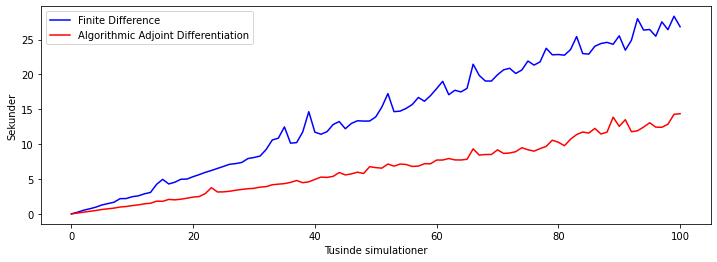

In [143]:
fig = plt.figure(figsize=(12,4))
x = np.linspace(0, 100, 1)
# fig.suptitle('Hastighed for beregning af optionspris og følsomheder')
plt.xlabel("Simulationer ('000)")
plt.ylabel('Sekunder')
plt.plot(time_FD, '-b', label='Finite Difference')
plt.plot(time_AAD, '-r', label='Algorithmic Adjoint Differentiation')
plt.legend(loc='upper left')
plt.show
plt.savefig('Beregningshastighed.png', bbox_inches='tight')